# Speech Emotion Recognition - SVM Classifier

A project for the French Employment Agency

Telecom ParisTech 2018-2019

## I. Context

The aim of this notebook is to set up all speech emotion recognition preprocessing and audio features extraction.

### Audio features:
The complete list of the implemented short-term features is presented below:
- **Zero Crossing Rate**: The rate of sign-changes of the signal during the duration of a particular frame.
- **Energy**: The sum of squares of the signal values, normalized by the respective frame length.
- **Entropy of Energy**: The entropy of sub-frames' normalized energies. It can be interpreted as a measure of abrupt changes.
- **Spectral Centroid**: The center of gravity of the spectrum.
- **Sprectral Spread**: The second central moment of the spectrum.
- **Spectral Entropy**: Entropy of the normalized spectral energies for a set of sub-frames.
- **Spectral Flux**: The squared difference between the normalized magnitudes of the spectra of the two successive frames.
- **Spectral Rolloff**: The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
- **MFCCS**: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

Global Statistics are then computed on upper features:
- **mean, std, med, kurt, skew, q1, q99, min, max and range**

### Data:
**RAVDESS**: The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes *calm*, *happy*, *sad*, *angry*, *fearful*, *surprise*, and *disgust* expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. (https://zenodo.org/record/1188976#.XA48aC17Q1J)

## II. General import

In [2]:
### General imports ###
from glob import glob
import os
import pickle
import itertools
import pandas as pd
import numpy as np

In [3]:
### Warning import ###
import warnings
warnings.filterwarnings('ignore')

### Graph imports ###
import matplotlib.pyplot as plt

### Sklearn imports ###
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## II. Import data

In [4]:
# Load datas from pickle
[features, labels] = pickle.load(open("/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/[RAVDESS][HAP-SAD-NEU-ANG-FEA-DIS-SUR][GLOBAL_STATS].p", "rb"))

In [5]:
len(labels)

2263

In [7]:
labels

array(['f_HAP', 'f_ANG', 'm_FEA', ..., 'm_SAD', 'm_HAP', 'm_ANG'],
      dtype='<U5')

In [6]:
np.unique(labels)

array(['f_ANG', 'f_DIS', 'f_FEA', 'f_HAP', 'f_NEU', 'f_SAD', 'f_SUR',
       'm_ANG', 'm_DIS', 'm_FEA', 'm_HAP', 'm_NEU', 'm_SAD', 'm_SUR'],
      dtype='<U5')

In [55]:
len(labels), labels[0]

(2263, 'f_HAP')

## III. Train and test data set

In [8]:
# Build Train and test dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=123)

# Encode Label from categorical to numerical
lb = LabelEncoder()
lb.fit(y_train)
y_train, y_test = lb.transform(y_train), lb.transform(y_test)

## IV. Scale features

In [9]:
# Scale train and test dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
len(X_train), len(X_test)

(1810, 453)

In [11]:
len(X_train[1])

200

## V. Feature selection

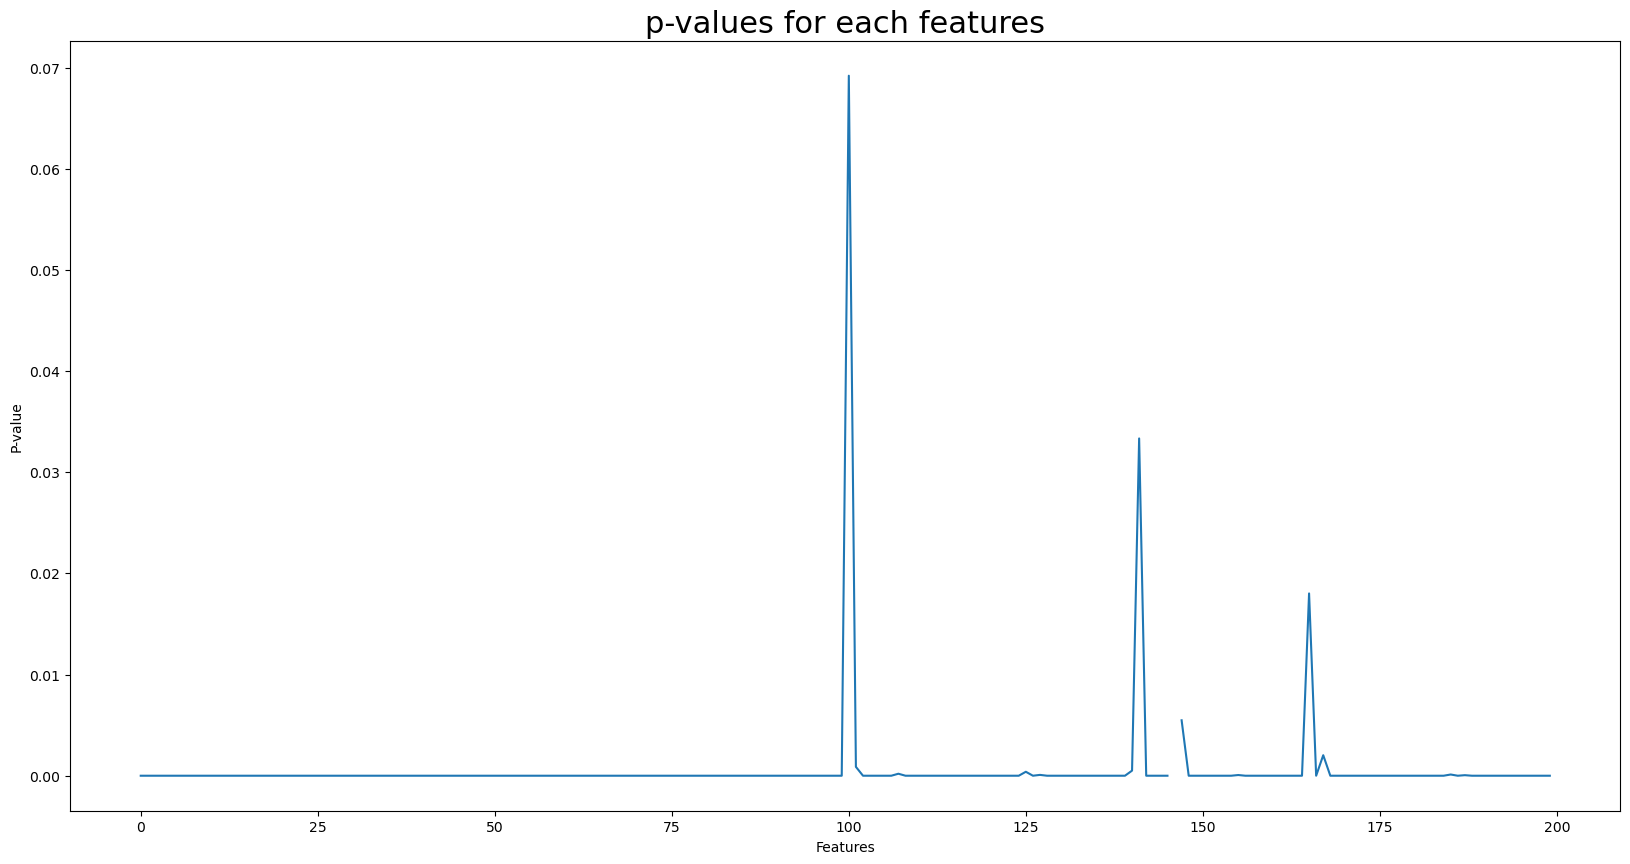

Number of p-values > à 1% : 3


In [12]:
# k-highest scores analysis on features
Kbest = SelectKBest(k="all")
selected_features = Kbest.fit(X_train, y_train)

# Plot P-values
plt.figure(figsize=(20, 10))
plt.plot(selected_features.pvalues_)
plt.title("p-values for each features", fontsize=22)
plt.xlabel("Features")
plt.ylabel("P-value")
plt.show()

# Display Comment
alpha = 0.01
print("Number of p-values > à 1% : {}".format(np.sum(selected_features.pvalues_ > alpha)))

In [13]:
# Remove non-significant features
X_train = X_train[:,np.where(selected_features.pvalues_ < alpha)[0]]
X_test = X_test[:,np.where(selected_features.pvalues_ < alpha)[0]]

In [14]:
len(X_train[0]), len(X_test[0])

(196, 196)

## VI. Feature dimension reduction

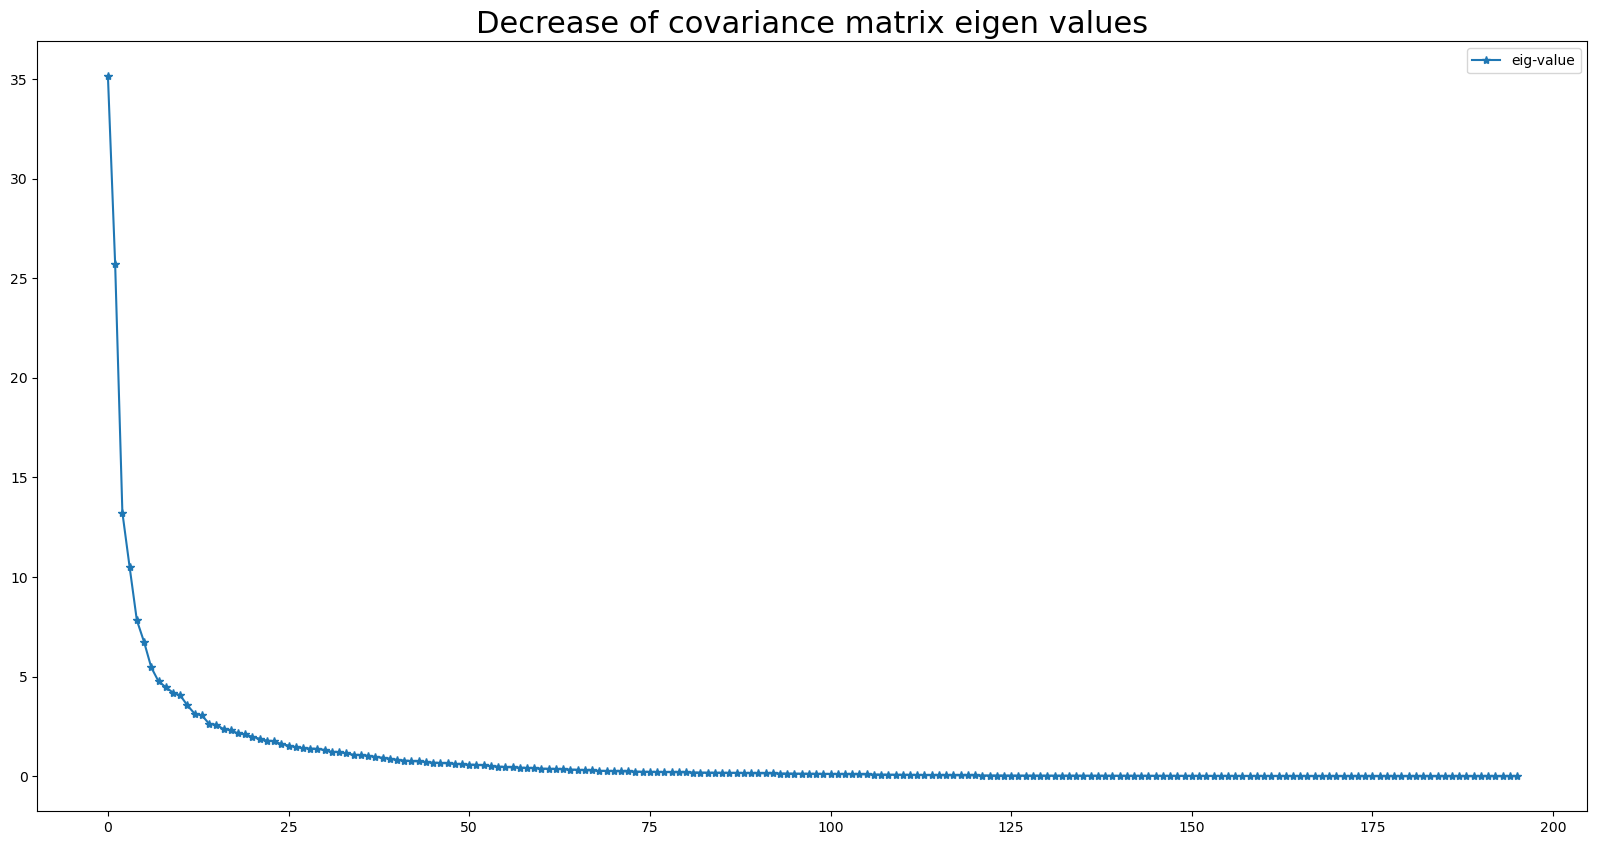

In [15]:
# Covariance matrix
cov = pd.DataFrame(X_train).cov()

# Eigen values of covariance matrix
eig = np.linalg.svd(cov)[1]

# Plot eigen graph
fig = plt.figure(figsize=(20, 10))
plt.title('Decrease of covariance matrix eigen values', fontsize = 22)
plt.plot(eig, '-*', label = "eig-value")
plt.legend(loc = 'upper right')
plt.show()

In [16]:
# Initialize PCA
pca = PCA(n_components=140)

# Apply PCA on train and test set
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [17]:
len(X_train[0]), len(X_test[0])

(140, 140)

## VII. Cross-Validation and hyperparameter tuning

In [26]:
len(y_train), len(y_test)

(1810, 453)

In [33]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [29]:
# Set C and Gamma parameters list
G_list = [0.001, 0.005, 0.01]
C_list = [1, 2, 3, 4, 5, 7, 10, 20, 50]

# Set the parameters for cross-validation
parameters = [{'kernel': ['rbf'], 'C': C_list, 'gamma': G_list}]

# Initialize SVM model
model = SVC(decision_function_shape='ovr')

# Cross Validation 
cv = GridSearchCV(model, parameters, cv=3, verbose=0, n_jobs=-1).fit(X_train, y_train)

# Print Best parameters
print("Best parameters set found on train set:")
print(cv.best_params_)

Best parameters set found on train set:
{'C': 7, 'gamma': 0.005, 'kernel': 'rbf'}


## VIII. Best model prediction

In [19]:
# Confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=22)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

Accuracy Score on test dataset: 69.76%


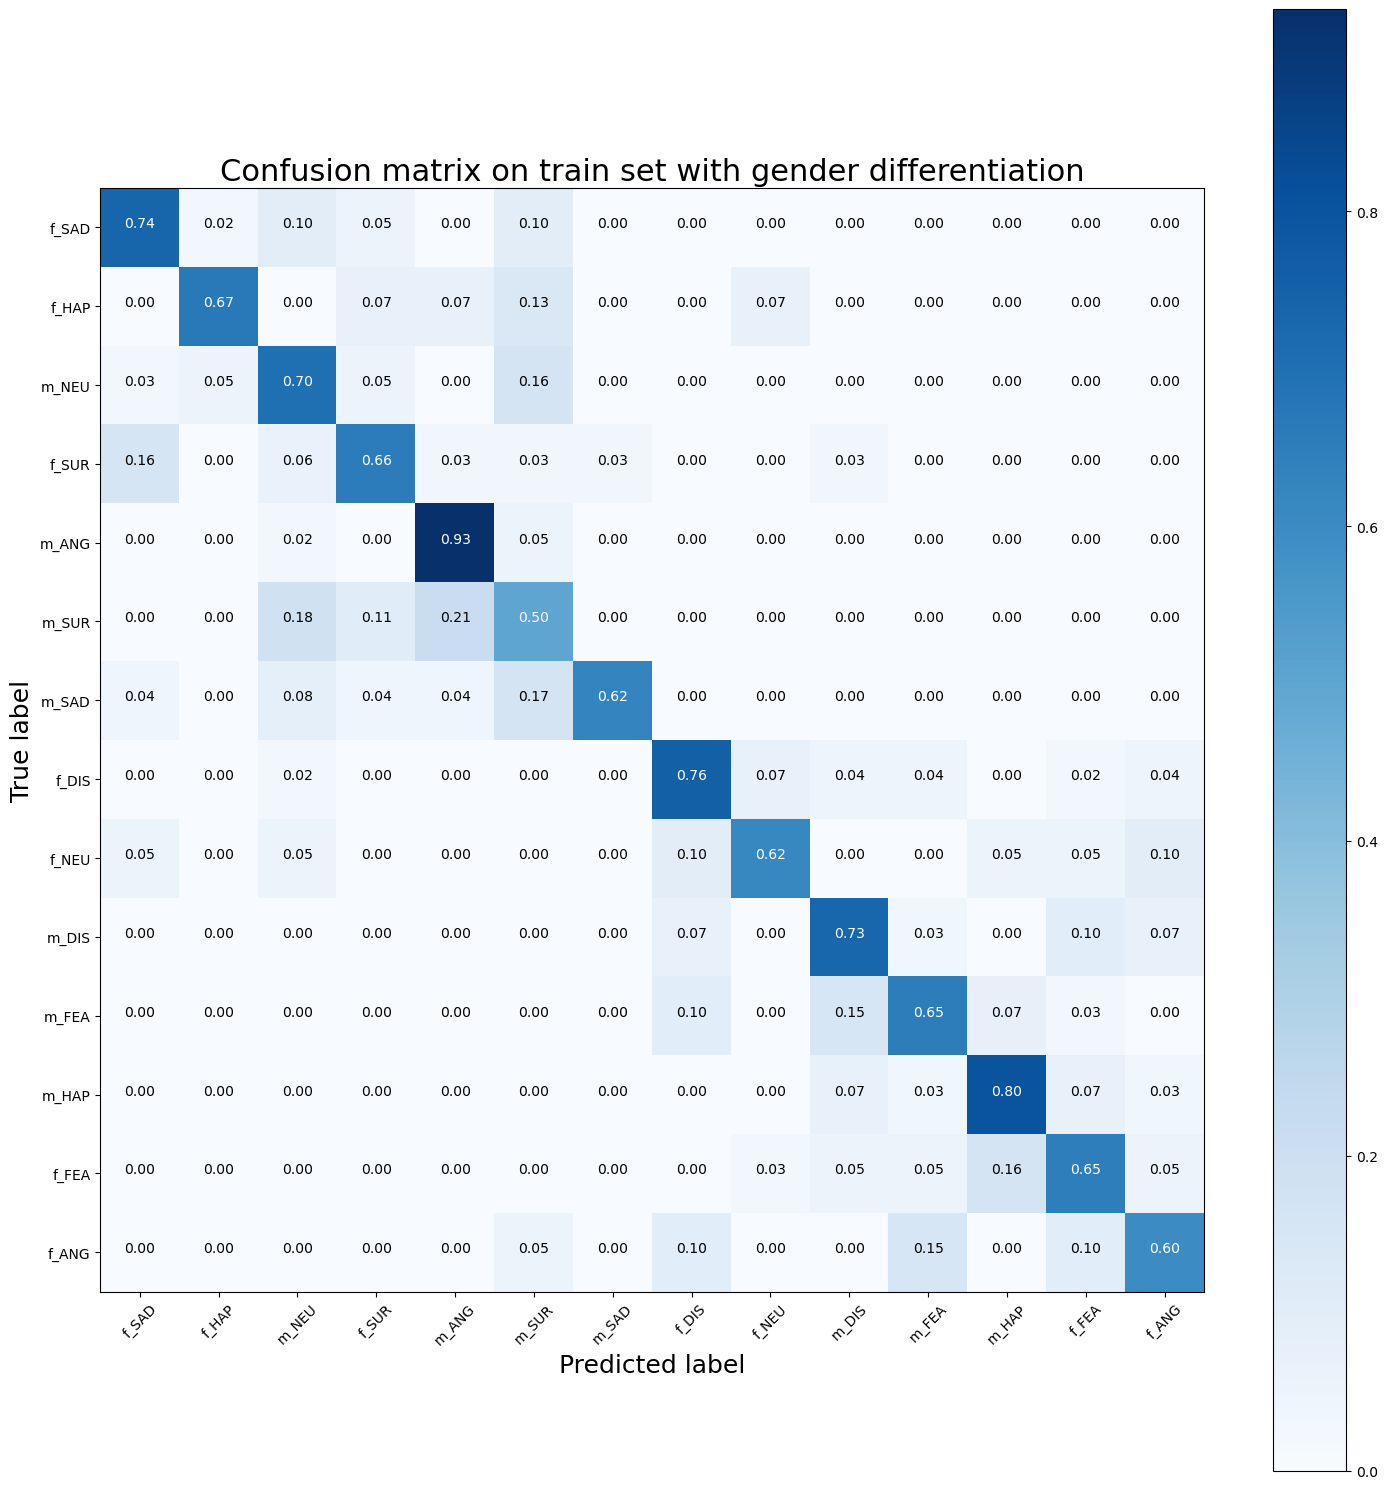

In [22]:
# Fit best mode
model = SVC(kernel='rbf', C=7, gamma=0.005, decision_function_shape='ovr').fit(X_train, y_train)

# Prediction
pred = model.predict(X_test)

# Score
score = model.score(X_test, y_test)

# Reverse label encoder
pred = (lb.inverse_transform((pred.astype(int).flatten())))
actual = (lb.inverse_transform((y_test.astype(int).flatten())))

# Build dataFrame
df_pred = pd.DataFrame({'Actual': actual, 'Prediction': pred})

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * score,2)))

# Compute confusion matrix
confusion = confusion_matrix(actual, pred)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=set(actual),normalize=True,
                      title='Confusion matrix on train set with gender differentiation')

Accuracy Score on test dataset: 69.98%


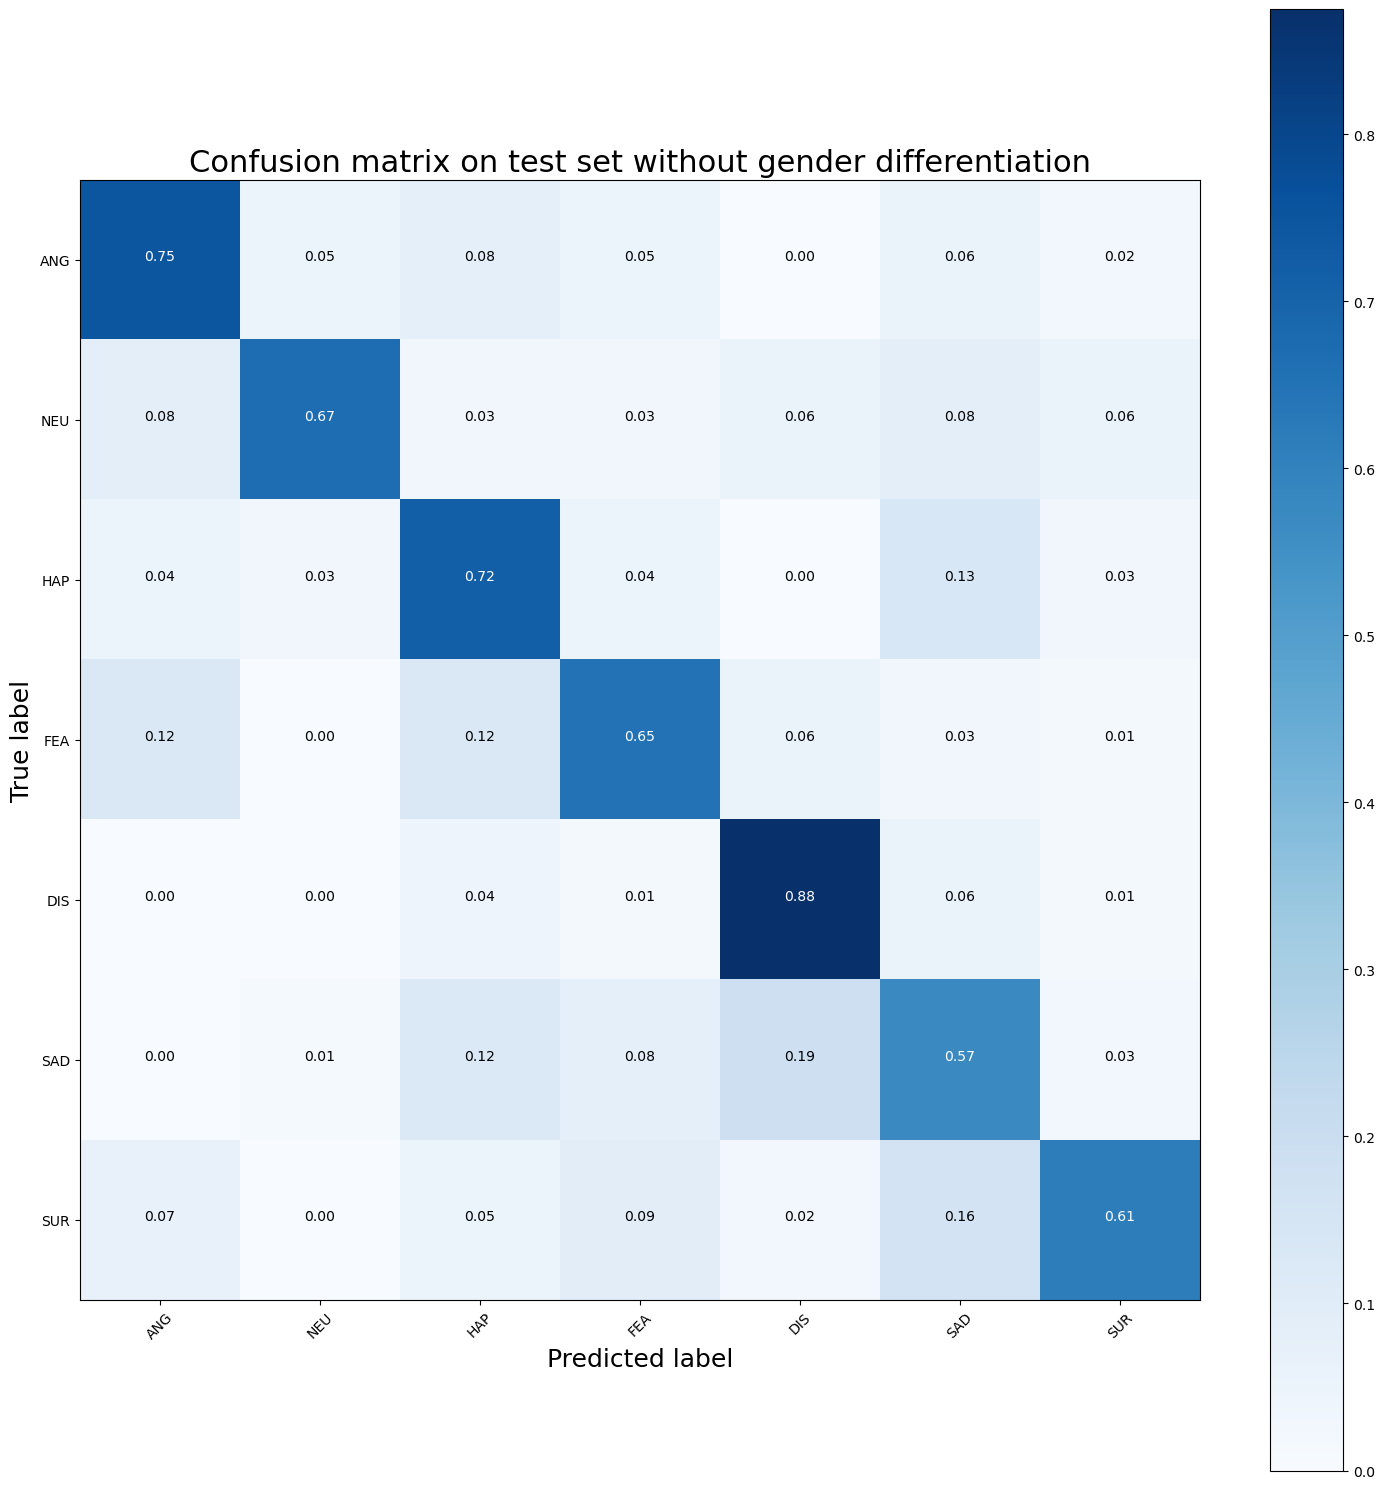

In [23]:
# Compute prediction without gender differentation
PRED = list(map(lambda i:i[2:], pred))
ACTUAL = list(map(lambda i:i[2:], actual))

# Compute related prediction score
SCORE = accuracy_score(ACTUAL, PRED)

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * SCORE,2)))

# Compute confusion matrix
confusion = confusion_matrix(ACTUAL, PRED)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=set(ACTUAL),normalize=True,
                      title='Confusion matrix on test set without gender differentiation')

## IX. Save model

In [24]:
# save the model to local
pickle.dump(model, open('/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/MODEL_CLASSIFIER.p', 'wb'))

# Save label encoder
pickle.dump(lb, open("/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/MODEL_ENCODER.p", "wb"))

# Save PCA
pickle.dump(pca, open("/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/MODEL_PCA.p", "wb"))

# Save MEAN and STD of each features
MEAN = features.mean(axis=0)
STD = features.std(axis=0)
pickle.dump([MEAN, STD], open("/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/MODEL_SCALER.p", "wb"))

# Save feature parameters
stats = ['mean', 'std', 'kurt', 'skew', 'q1', 'q99']
features_list = ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'sprectral_rolloff']
win_step = 0.01
win_size = 0.025
nb_mfcc = 12
diff = 0
PCA = True
DICO = {'stats':stats, 'features_list':features_list, 'win_size':win_size, 'win_step':win_step, 'nb_mfcc':nb_mfcc, 'diff':diff, 'PCA':PCA}
pickle.dump(DICO, open("/home/23m1508/MTP IIB IEOR 2024-25/Multi-Model-Emotion-Recognition/Multimodal-Emotion-Recognition-master/Audio/saved pickle/MODEL_PARAM.p", "wb"))

# X. Experiment with XG Boost Algorithm

In [35]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Set parameters list for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [5, 10, 15, 20, 30, 50],
    'n_estimators': [50, 100, 200, 500, 600]
}

# Initialize XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=14)

# Cross Validation
cv = GridSearchCV(model, param_grid, cv=3, verbose=1, n_jobs=-1).fit(X_train, y_train)

# Print Best parameters
print("Best parameters set found on train set:")
print(cv.best_params_)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
Best parameters set found on train set:
{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500}


In [36]:
# Fit best model
best_params = {'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 500, 'objective': 'multi:softmax', 'num_class': 14}
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None, num_class=14,
              num_parallel_tree=None, ...)

Accuracy Score on test dataset: 55.19%


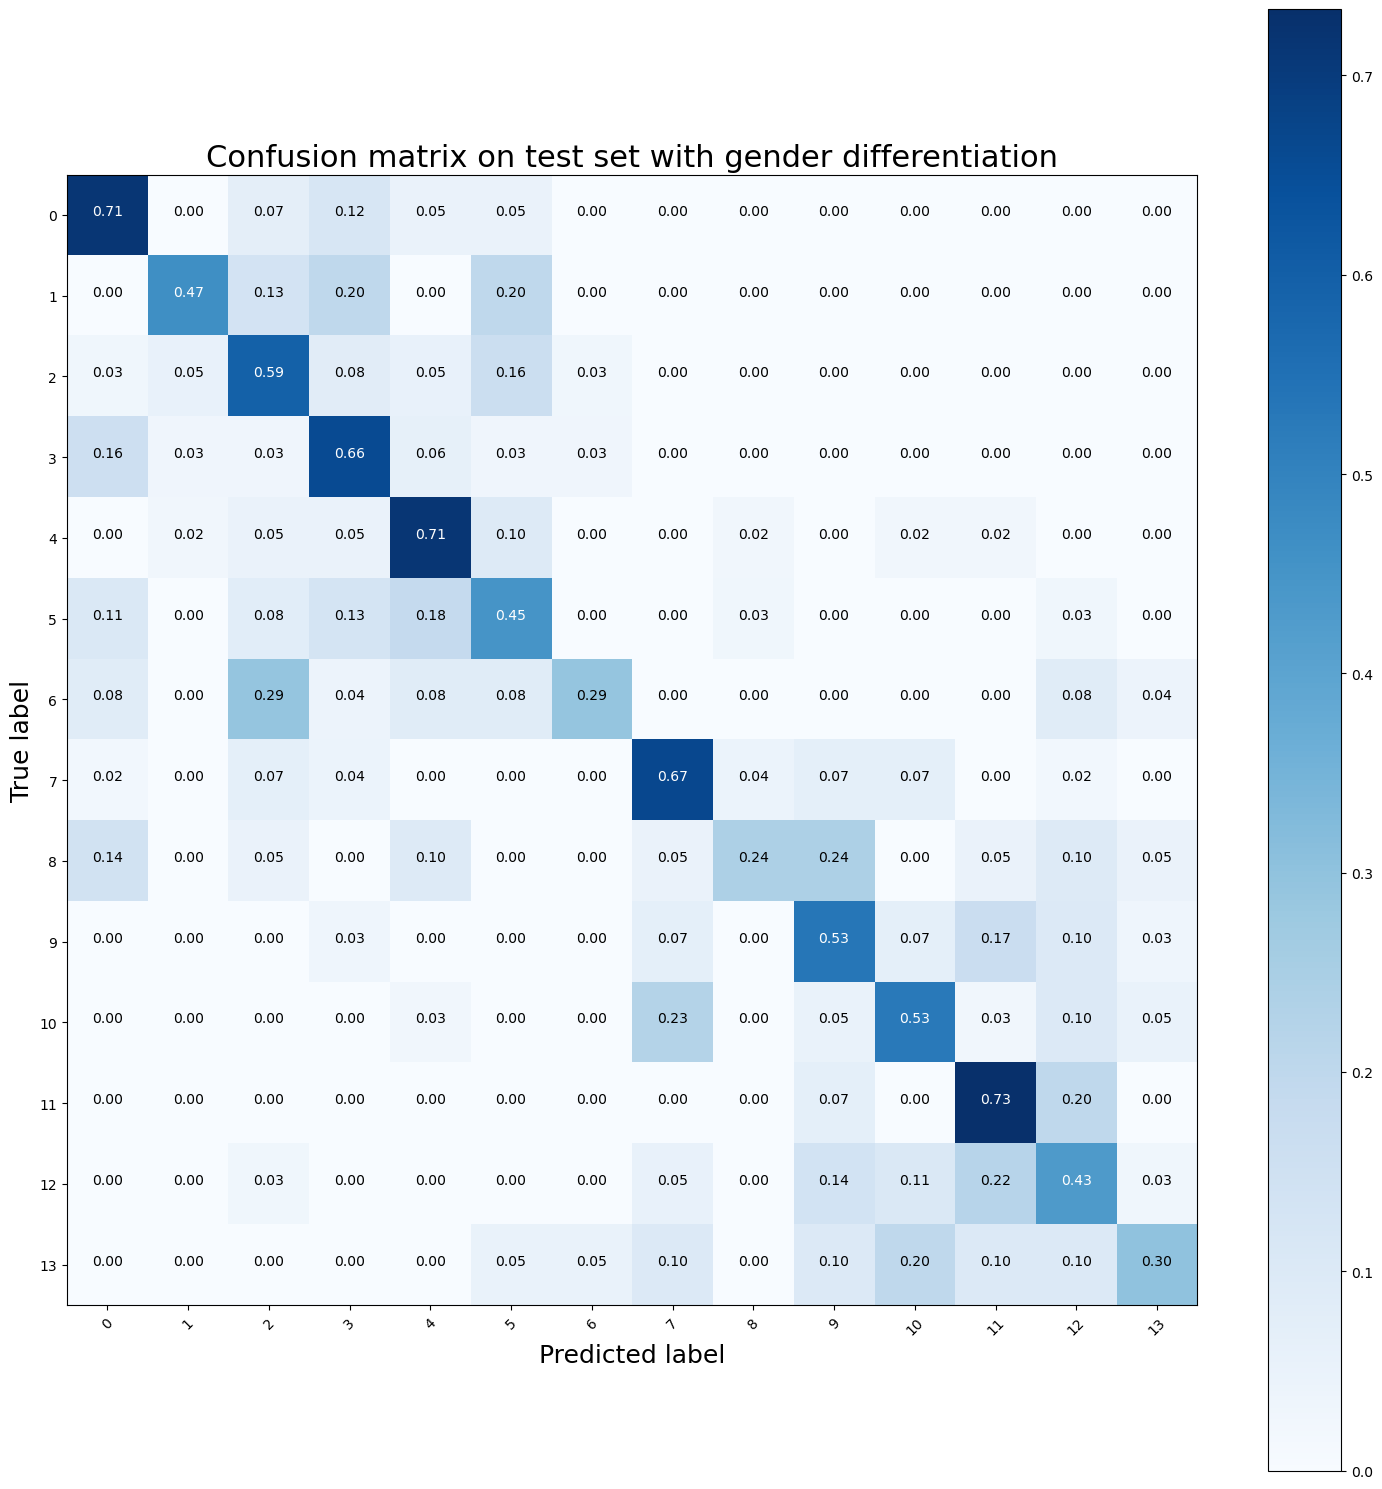

In [38]:
# Prediction
pred = model.predict(X_test)

# Score
score = accuracy_score(y_test, pred)

# Reverse label encoder
lb = LabelEncoder()
lb.fit(np.concatenate((y_train, y_test), axis=0))  # Assuming you want to inverse transform using the combined classes
pred = lb.inverse_transform(pred.astype(int).flatten())
actual = lb.inverse_transform(y_test.astype(int).flatten())

# Build dataFrame
df_pred = pd.DataFrame({'Actual': actual, 'Prediction': pred})

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * score, 2)))

# Compute confusion matrix
confusion = confusion_matrix(actual, pred)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=set(actual), normalize=True,
                      title='Confusion matrix on test set with gender differentiation')

In [47]:
# Compute prediction without gender differentation
PRED = list(map(lambda i:i[2:], pred))
ACTUAL = list(map(lambda i:i[2:], actual))

# Compute related prediction score
SCORE = accuracy_score(ACTUAL, PRED)

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * SCORE,2)))

# Compute confusion matrix
confusion = confusion_matrix(ACTUAL, PRED)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=set(ACTUAL),normalize=True,
                      title='Confusion matrix on test set without gender differentiation')

IndexError: invalid index to scalar variable.

In [92]:
params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'gamma': 0,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
}

# Initialize XGBoost classifier with specified parameters
xgb_classifier = xgb.XGBClassifier(**params)

# Train the classifier
xgb_classifier.fit(X_train, y_train1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [103]:
y_train11 = []
y_test11 = []

for i in range(1810):
    for j in range(14):
        if y_train1[i, j] == 1 :
            y_train11.append(j)

for i in range(453):
    for j in range(14):
        if y_test1[i, j] == 1 :
            y_test11.append(j)

In [108]:
y_train11 = np.array(y_train11)
y_test11 = np.array(y_test11)

# Experiment with KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# Set the parameters for cross-validation
parameters = {
    'n_neighbors': [3, 5, 7, 10, 15],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function
    'p': [1, 2]  # Power parameter for the Minkowski distance
}

# Initialize KNN model
model = KNeighborsClassifier()

# Cross Validation
cv = GridSearchCV(model, parameters, cv=3, verbose=0, n_jobs=-1).fit(X_train, y_train)

# Print Best parameters
print("Best parameters set found on train set:")
print(cv.best_params_)


Best parameters set found on train set:
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


Accuracy Score on test dataset: 55.63%


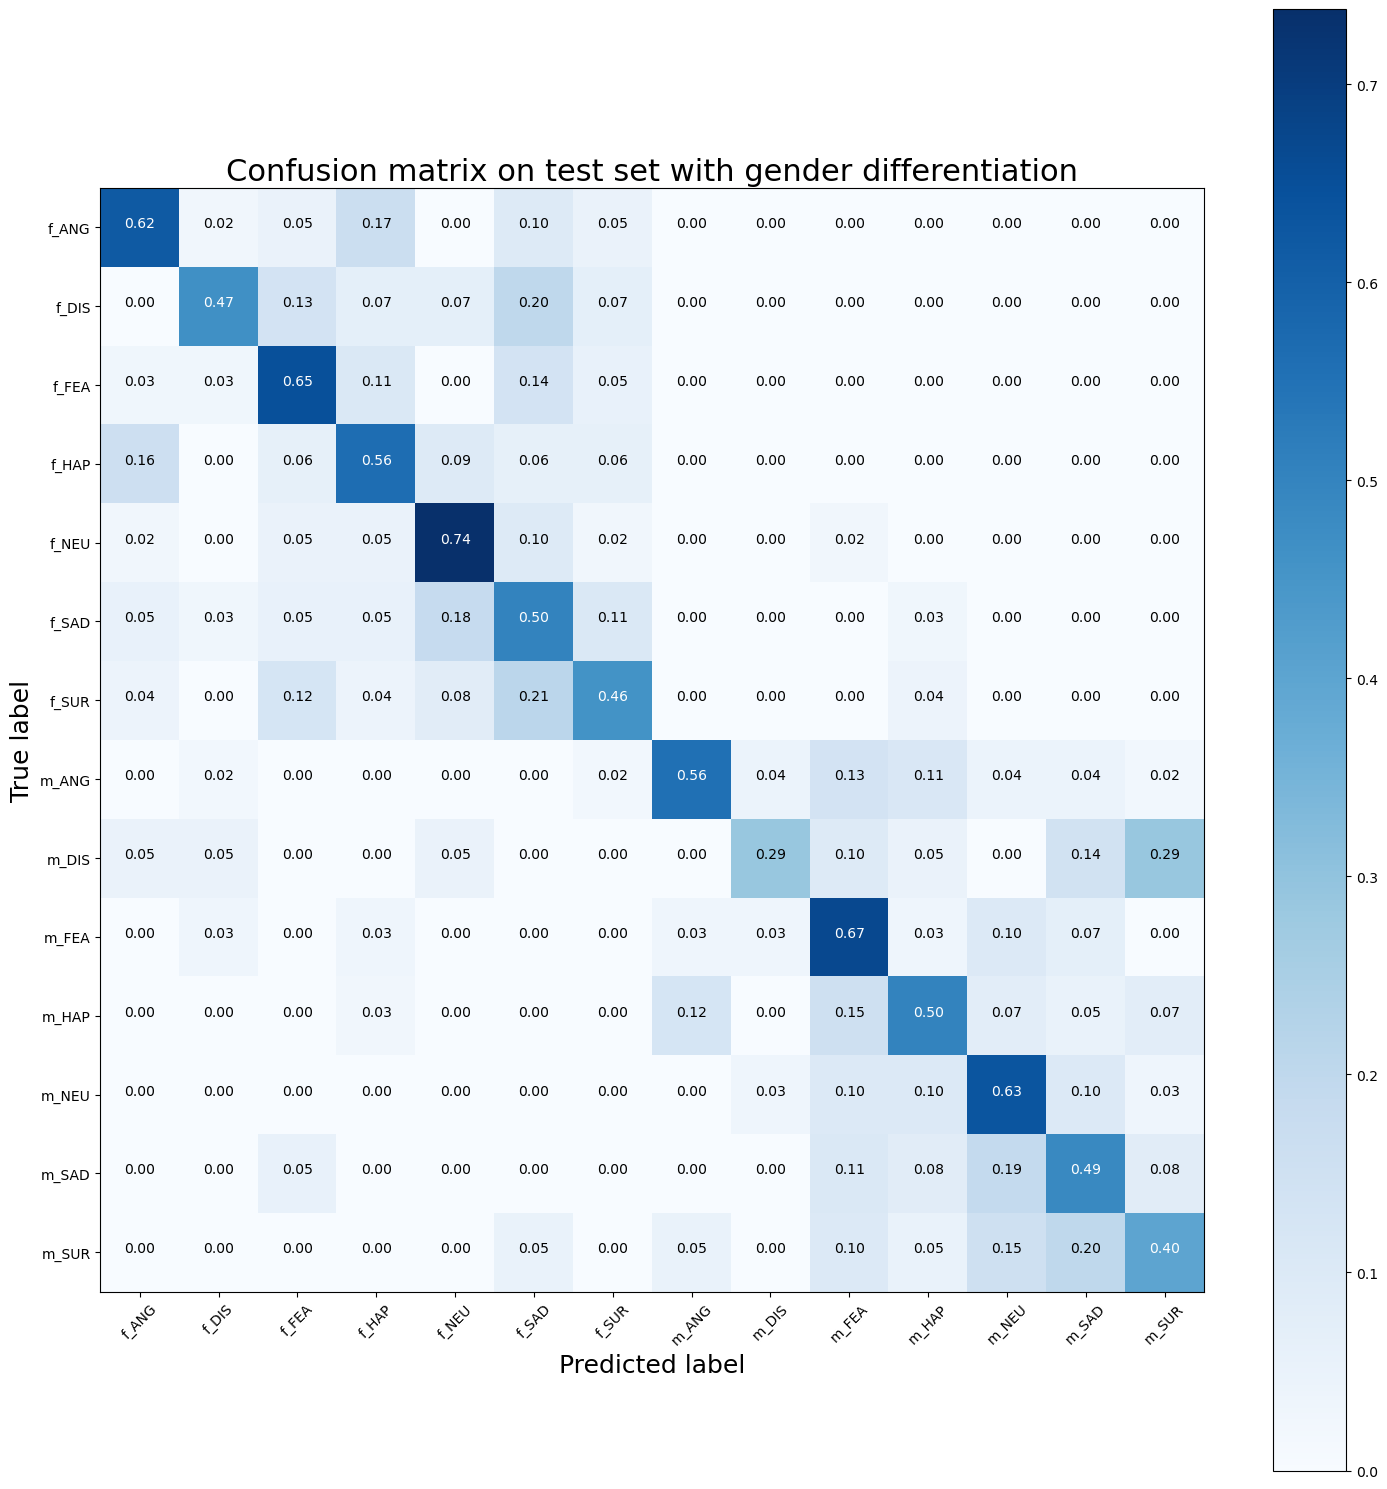

In [21]:
# Fit best model
model = KNeighborsClassifier(n_neighbors=3, p=1, weights='distance').fit(X_train, y_train)

# Prediction
pred = model.predict(X_test)

# Score
score = model.score(X_test, y_test)

# Reverse label encoder
pred = lb.inverse_transform(pred.astype(int).flatten())
actual = lb.inverse_transform(y_test.astype(int).flatten())

# Build dataFrame
df_pred = pd.DataFrame({'Actual': actual, 'Prediction': pred})

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * score, 2)))

# Compute confusion matrix
confusion = confusion_matrix(actual, pred, labels=lb.classes_)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, classes=lb.classes_, normalize=True,
                      title='Confusion matrix on test set with gender differentiation')
plt.show()

## Random Forests

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Set the parameters for cross-validation
parameters = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest model
model = RandomForestClassifier()

# Cross Validation
cv = GridSearchCV(model, parameters, cv=3, verbose=0, n_jobs=-1).fit(X_train, y_train)

# Print Best parameters
print("Best parameters set found on train set:")
print(cv.best_params_)


Best parameters set found on train set:
{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


Accuracy Score on test dataset: 46.14%


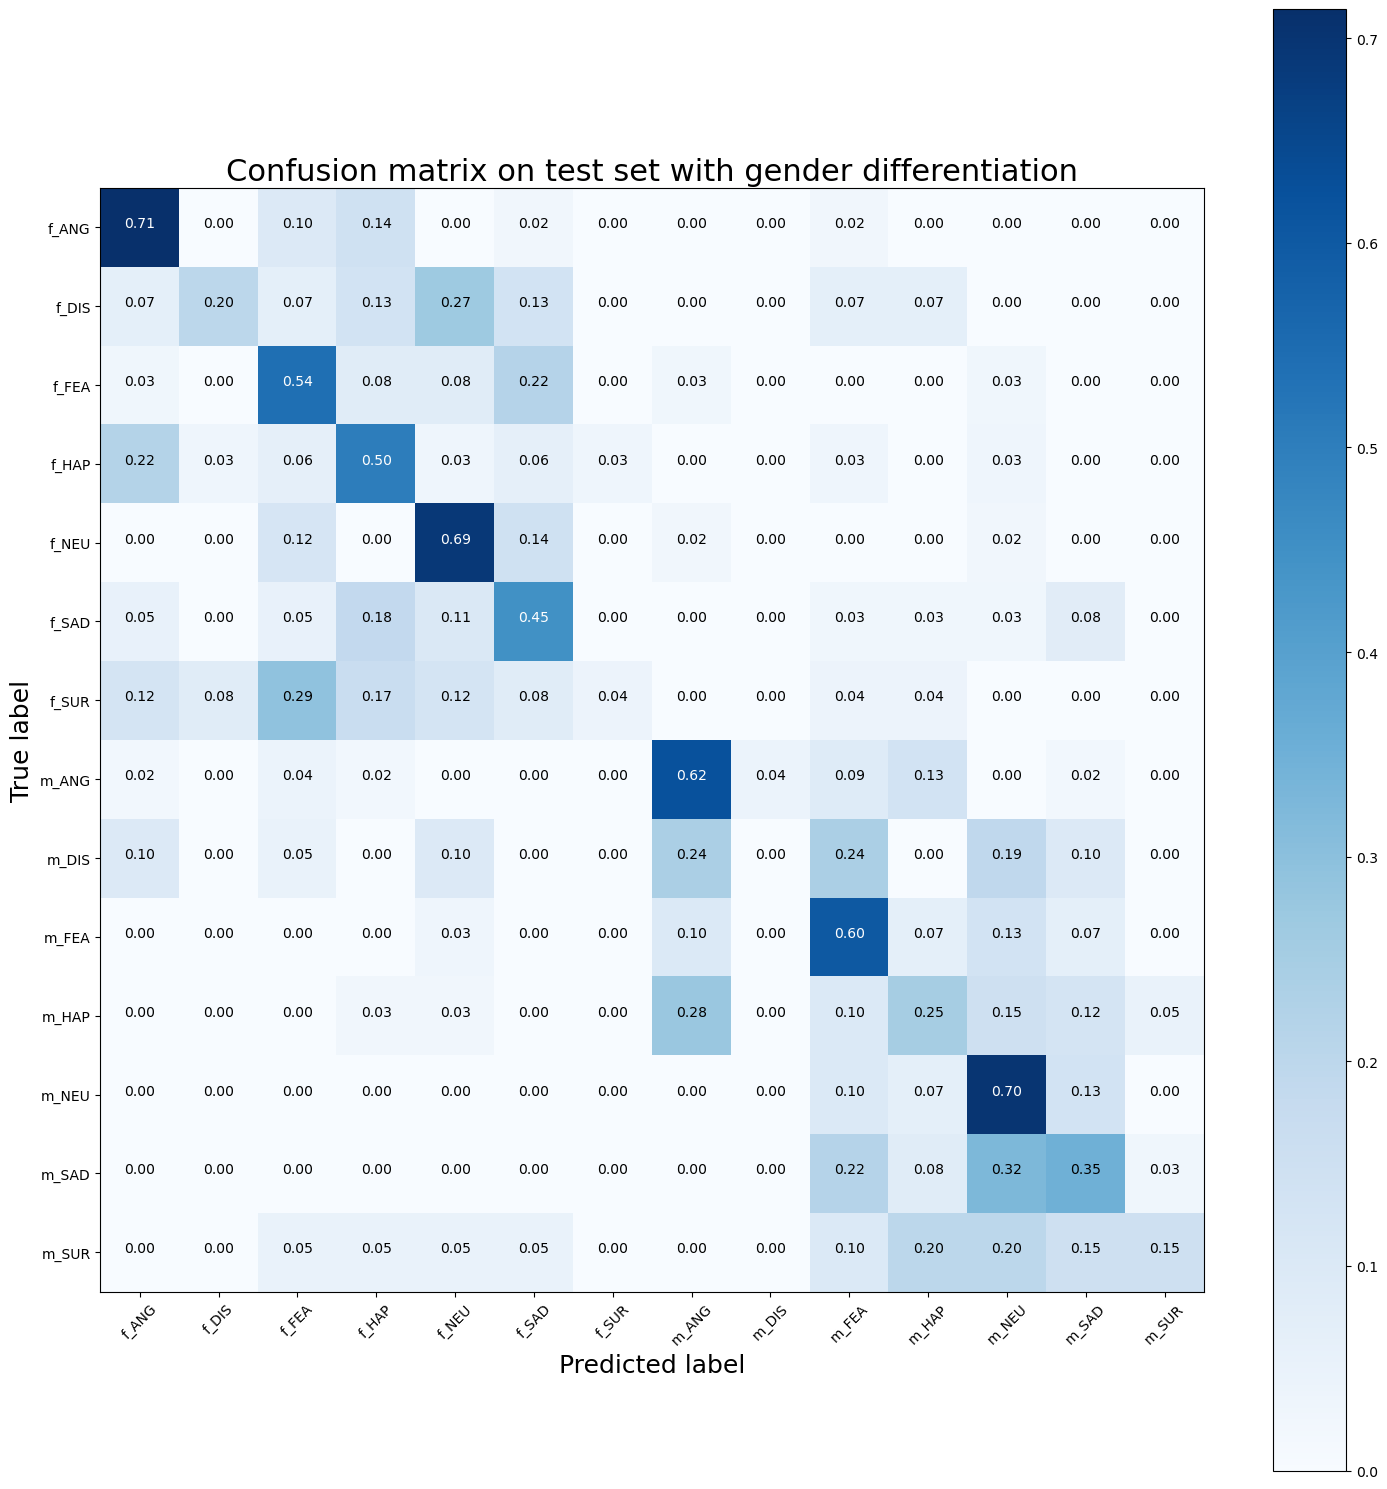

In [32]:
# Fit best model
best_params = cv.best_params_
model = RandomForestClassifier(**best_params).fit(X_train, y_train)

# Prediction
pred = model.predict(X_test)

# Score
score = model.score(X_test, y_test)

# Reverse label encoder
pred = lb.inverse_transform(pred.astype(int).flatten())
actual = lb.inverse_transform(y_test.astype(int).flatten())

# Build dataFrame
df_pred = pd.DataFrame({'Actual': actual, 'Prediction': pred})

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * score, 2)))

# Compute confusion matrix
confusion = confusion_matrix(actual, pred, labels=lb.classes_)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(confusion, 
                      classes=lb.classes_, normalize='true',
                      title='Confusion matrix on test set with gender differentiation')
plt.show()